In [1]:
import enspp.vis as vis
import numpy as np
import pandas as pd
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import STAP
import scipy.stats as stats
import scipy.optimize as opt
import seaborn as sns
import statsmodels.api as sm
import stoc_solar
import matplotlib.pyplot as plt
import xarray as xr
from wrfpywind import data_preprocess as pp

In [2]:
# Activate pandas2ri
pandas2ri.activate()

In [3]:
# Read the file with the R code
with open('../R/gamma_bma.r', 'r') as f:
    string = f.read()

# Parse the package using STAP
gamma_bma = STAP(string, "gamma_bma")

## Read in the ensemble and observational data

In [4]:
wrfens = pp.fmt_wrfens_wspd(wrfout_headdir='../data/', 
                    wrfout_dirs=['28mp4lw4sw2lsm5pbl1cu/',  # Lee 2017
                                 '8mp1lw1sw2lsm1pbl1cu/',  # Draxl 2014a
                                 '8mp1lw1sw2lsm2pbl1cu/',  # Draxl 2014b
                                 '8mp1lw1sw2lsm2pbl3cu/',  # Vernon 2018
                                 '8mp4lw2sw2lsm5pbl3cu/',  # Optis 2021
                                 ],
                    wrfout_files=['ow_buoy_wrfout_d03_2020-02-05-2020-02-11',
                                #   'ow_buoy_wrfout_d03_2020-06-03-2020-06-09',
                                #   'ow_buoy_wrfout_d03_2020-07-01-2020-07-07',
                                #   'ow_buoy_wrfout_d03_2020-11-26-2020-12-02',
                                  ],
                    model_names=['Lee 2017', 'Draxl 2014a', 'Draxl 2014b', 'Veron 2018', 'Optis 2021'],
                    heights=[20, 40, 60, 80, 100, 120, 140, 160, 180, 200],
                    locations=['south', 'north']
                    )

/Users/jeffreysward/opt/anaconda3/envs/enspp/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'pressure' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/jeffreysward/opt/anaconda3/envs/enspp/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'pressure' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/jeffreysward/opt/anaconda3/envs/enspp/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'pressure' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/jeffreysward/opt/anaconda3/envs/enspp/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'pressure' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/jeffr

In [5]:
obs = pp.fmt_buoy_wspd(data_path='/Users/jeffreysward/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/oshwind/wrfpywind/wrfpywind/data/nyserda_buoy/', 
                       south_dates_str='20190904_20210207', north_dates_str='20190812_20210207', 
                       heights=[20, 40, 60, 80, 100, 120, 140, 160, 180, 200],
                       start_date='01-01-2020', end_date='12-31-2020')

In [6]:
# Get data for only north buoy at 100m and format
wrfens_n = wrfens.sel(location='north', height=100)
wrfens_n = wrfens_n.T.to_pandas()
obs_n = obs.sel(location='north', height=100)
obs_n = obs_n.to_pandas()

In [7]:
# Get data for only north buoy at 100m and format
wrfens_s = wrfens.sel(location='south', height=100)
wrfens_s = wrfens_s.T.to_pandas()
obs_s = obs.sel(location='south', height=100)
obs_s = obs_s.to_pandas()

In [8]:
# Put the observations and the ensemble forecast into the same DataFrame (north buoy)
data_n = pd.concat([obs_n['2020-02-05':'2020-02-11'], wrfens_n], axis=1)
data_n = data_n.rename(columns={0: 'Obs'})
data_n = data_n.dropna().reset_index()
data_n.head()

,Time,Obs,Lee 2017,Draxl 2014a,Draxl 2014b,Veron 2018,Optis 2021
0,2020-02-05 00:00:00,14.2556,12.764170,10.433875,11.339193,11.961639,13.301400
1,2020-02-05 00:10:00,14.7611,12.745060,10.433420,11.272497,11.955648,13.316387
2,2020-02-05 00:20:00,14.4694,12.712714,10.446456,11.138189,11.852893,13.370154
3,2020-02-05 00:30:00,14.1879,12.750162,10.528953,11.026620,11.748485,13.386228
4,2020-02-05 00:40:00,13.8947,12.827484,10.565650,10.871380,11.613228,13.371477


In [9]:
# Put the observations and the ensemble forecast into the same DataFrame (south buoy)
data_s = pd.concat([obs_s['2020-02-05':'2020-02-11'], wrfens_s], axis=1)
data_s = data_s.rename(columns={0: 'Obs'})
data_s = data_s.dropna().reset_index()
data_s.head()

,Time,Obs,Lee 2017,Draxl 2014a,Draxl 2014b,Veron 2018,Optis 2021
0,2020-02-05 00:00:00,13.6505,13.685442,12.866231,12.568259,12.277505,13.863934
1,2020-02-05 00:10:00,14.2122,13.363071,12.655890,12.290730,12.144863,13.552567
2,2020-02-05 00:20:00,14.1298,13.146239,12.361849,12.176544,12.044481,13.266779
3,2020-02-05 00:30:00,14.3854,13.092661,12.025348,12.141987,11.898691,12.898476
4,2020-02-05 00:40:00,14.3856,13.005664,11.788001,12.132236,11.859801,12.588501


In [10]:
# Combine the data from the two buoys into the same dataframe 
data = pd.concat([data_s, data_n], axis=0)

## Fit a BMA model
We will estimate the BMA parameters using the R `ensembleBMA` package with the help of the `rpy2` Python package

Since the Sloughter 2010 paper use the gamma distribution, I think I'll just proceed with the Gamma distribution.

In [11]:
# Split the data into training and testing sets
train_data = data[data['Time'] < '2020-02-11'].reset_index()
test_data = data[data['Time'] >= '2020-02-11'].reset_index()

In [12]:
# Fit the BMA model 
fit = gamma_bma.fit_bma(train_data, n_ens_members=5)
print(fit)

$biasCoefs
[1] 1.5681511 0.8912485

$varCoefs
[1] 2.060378e+00 2.381396e-14

$weights
   Lee 2017 Draxl 2014a Draxl 2014b  Veron 2018  Optis 2021 
 0.34480300  0.19491841  0.21004349  0.05466452  0.19557058 

$nIter
[1] 208

$loglikelihood
[1] -3449.187

$power
[1] 1

$startupSpeed
[1] 0

$call
fitBMAgamma(ensembleData = train_ensd, control = controlBMAgamma(startupSpeed = 0))

attr(,"class")
[1] "fitBMAgamma" "fitBMA"     



Note that typing `print(fit)` into the notbook allows you to view the BMA fit, but that simply typing `fit` will draw an uninteligable error for Jupyter

In [13]:
# Extract the quantiles for a set set of testing data. In this case, 
# we don't want to supply the full set of testing data as this includes both locations, 
# so we will first define a new set of testing data.
test_n = data_n[data_n['Time'] >= '2020-02-11'].reset_index()
q = gamma_bma.quant_bma(fit, test_n, n_ens_members=5, quantiles=np.arange(0.01, 1, 0.01))

In [14]:
# Calculate the CRPS
crps = gamma_bma.crps_bma(fit, test_data, n_ens_members = 5)

In [15]:
# To determine the optimal amount of training data, I will probably use the mean CRPS
np.mean(crps)

1.6233723350146374

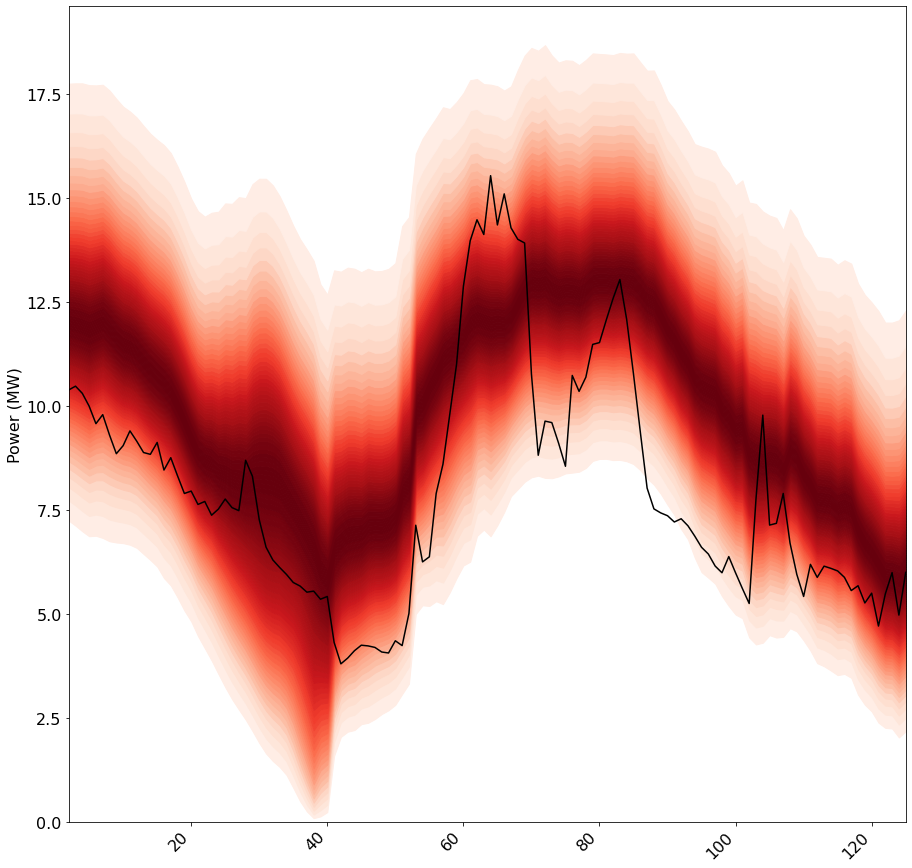

In [16]:
# Visualize the forecast and observations using stoc_solar.fan
stoc_solar.fan(fx=q.T, obs=test_n.Obs.values, p1=None, p2=None, t_issue='01/01/2018', fx_res='H', title=None, 
               percentile_vals=[ii + 1 for ii in range(0, 99)], fig_w=15,
               ylab=True, show_fig=True)

While it's nice that my `stoc_solar.fan` plot works okay here, I think I'm going to duplicate this function for `enspp` and customize it for wind speed -- hopefully this version will be more portable.  
Also, this will require some formatting of the `fx` and `obs` input variables.

In [17]:
# Format the forecast and obs variables into xarray DataSets. Note the obnoxious bug, 
# which means that I had to write test_n.Time[0:1] rather than simply test_n.Time
fx = xr.DataArray(
    data=[q],
    dims=[
        "Start_time", 
        "Step_index", 
        "Percentile"
        ],
    coords=dict(
        Start_time=test_n.Time[0:1],
        Step_index=test_n.index,
        Percentile=np.arange(1, 100, 1),
    ),
    attrs=dict(
        description="Wind Speed 100m",
        units="m s-1",
    ),
)

For the observations, I can simply use the `obs` `xarray.DataSet` that I read in using `pp.fmt_buoy_wspd`

In [29]:
obs_n_100 = obs.sel(location='north', height=100)

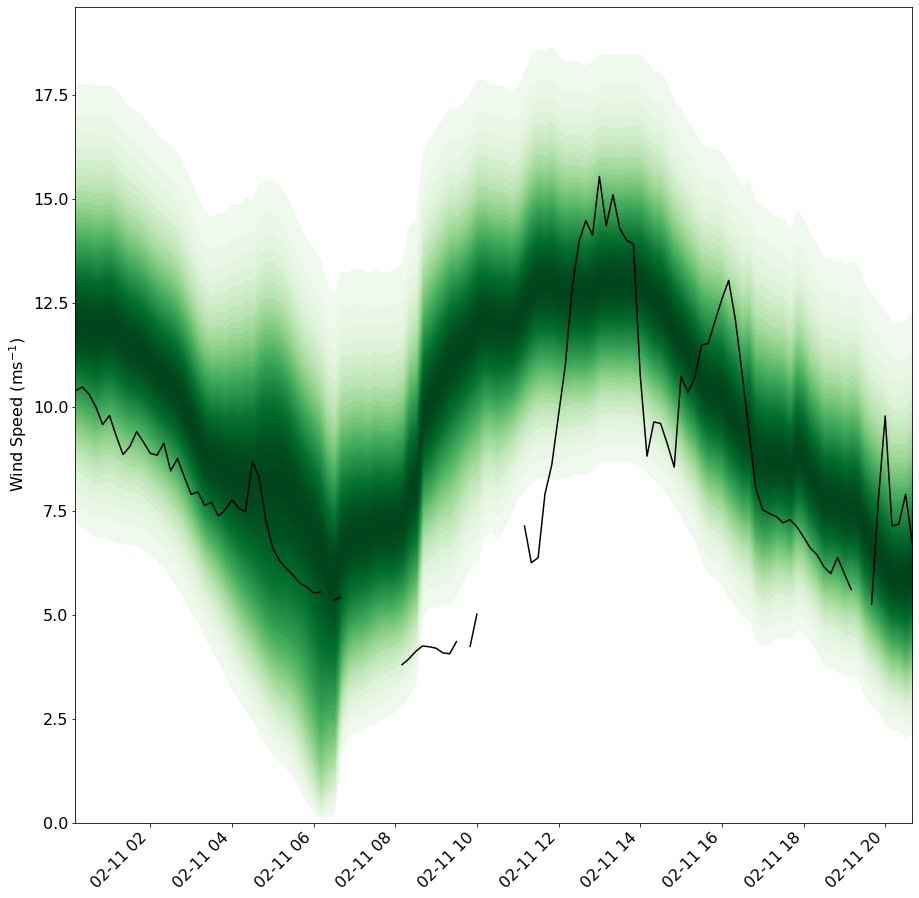

In [31]:
vis.fan(fx=fx, obs=obs_n_100, p1=None, p2=None, t_issue='02/11/2020', n_days=1, fx_res='10T', title=None, 
    percentile_vals=None, fig_w=15, ylab=True, ylab_txt='Wind Speed (ms$^{-1}$)', 
    show_fig=True, save_fig=False, fig_path='../data/plots/fan_plot.png')

## Create a Map of a Specific Quantile 

In [1]:
# Read in data from the full domain